# 时间序列分析

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg

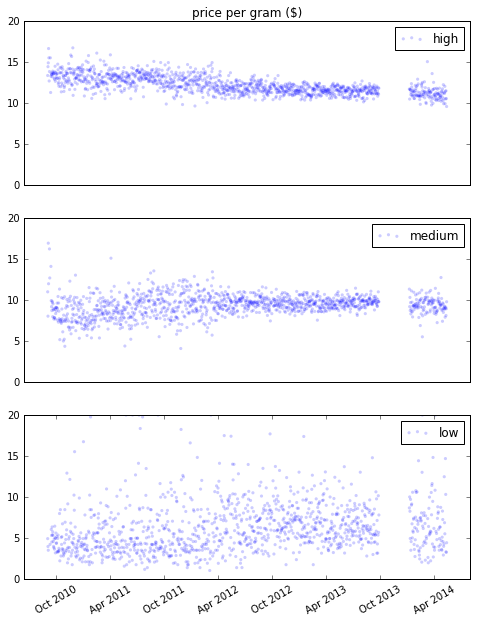

In [4]:
import matplotlib.pyplot as pyplot
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa

def ReadData():
    """Reads data about cannabis transactions.

    http://zmjones.com/static/data/mj-clean.csv

    returns: DataFrame
    """
    transactions = pandas.read_csv('mj-clean.csv', parse_dates=[5])
    return transactions

def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    groups = transactions[['date', 'ppg']].groupby('date')
    daily = groups.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    return daily

def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        
    return dailies

def PlotDailies(dailies):
    """Makes a plot with daily prices for different qualities.

    dailies: map from name to DataFrame
    """
    thinkplot.PrePlot(rows=3)
    for i, (name, daily) in enumerate(dailies.items()):
        thinkplot.SubPlot(i+1)
        title = 'price per gram ($)' if i == 0 else ''
        thinkplot.Config(ylim=[0, 20], title=title)
        thinkplot.Scatter(daily.ppg, s=10, label=name)
        if i == 2: 
            pyplot.xticks(rotation=30)
        else:
            thinkplot.Config(xticks=[])

transactions = ReadData()
dailies = GroupByQualityAndDay(transactions)
PlotDailies(dailies)

上图有个明显的特点：2013年11月附近有一个缺口。从图中可以看到，这段时间内，高质量大麻的价格似乎在降低，中等质量和低质量大麻的价格似乎在提高。

## 线性回归

In [5]:
def RunLinearModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

def RunModels(dailies):
    """Runs linear regression for each group in dailies.

    dailies: map from group name to DataFrame
    """
    rows = []
    for name, daily in dailies.items():
        _, results = RunLinearModel(daily)
        intercept, slope = results.params
        p1, p2 = results.pvalues
        r2 = results.rsquared
        s = r'%s: %0.3f (%0.2g) | %0.3f (%0.2g) | %0.3f'
        row = s % (name, intercept, p1, slope, p2, r2)
        rows.append(row)
    for row in rows:
        print(row)
RunModels(dailies)

high: 13.450 (0) | -0.708 (3.7e-160) | 0.444
medium: 8.879 (0) | 0.283 (1.8e-15) | 0.050
low: 5.362 (3.1e-130) | 0.568 (2.8e-09) | 0.030


估计所得斜率说明，在观测区间内，高质量大麻的价格每年下降约71%；中等质量大麻的价格每年上涨28%；低质量大麻价格每年上涨57%。这些估计都是统计显著的，p很小。

高质量大麻的$R^2$值为0.44，说明以时间为解释变量，可以解释说观测到的价格变化的44%。其他两类的价格变化较小，价格可变性较高，因此$R^2$值较小（但仍然是统计显著的）。

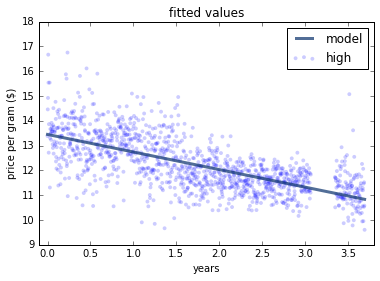

In [6]:
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')

def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.
    
    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(root='timeseries2',
                   title='fitted values',
                   xlabel='years',
                   xlim=[-0.1, 3.8],
                   ylabel='price per gram ($)')

name = 'high'
daily = dailies[name]
PlotLinearModel(daily, name)

线性回归并不是拟合这种数据最适宜的方法：
- 首先，预测长期趋势为线性的或符合其他简单函数，这是没有依据的。通常，价格由供需关系决定，而供给和需求都会随着时间发生不可预期的变化。
- 其次，线性回归模型对所有数据使用同样的权重，不管是过去的还是近期数据。在进行预测时，近期数据也许应该得到更多的权重。
- 最后，线性回归假设残差是无关的噪音。而在时间序列数据中，相邻数据是相关的，这项假设通常不能成立。

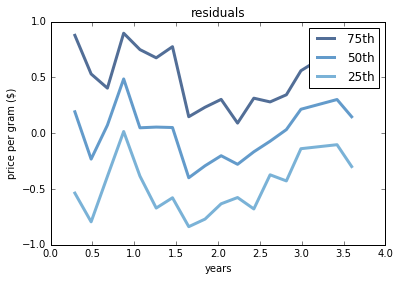

In [7]:
def PlotResidualPercentiles(model, results, index=1, num_bins=20):
    """Plots percentiles of the residuals.

    model: StatsModel model object
    results: StatsModel results object
    index: which exogenous variable to use
    num_bins: how many bins to divide the x-axis into
    """
    exog = model.exog[:, index]
    resid = results.resid.values
    df = pandas.DataFrame(dict(exog=exog, resid=resid))

    bins = np.linspace(np.min(exog), np.max(exog), num_bins)
    indices = np.digitize(exog, bins)
    groups = df.groupby(indices)

    means = [group.exog.mean() for _, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.resid) for _, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(means, percentiles, label=label)

def PlotLinearModelRes(daily, name):
    model, results = RunLinearModel(daily)
    PlotResidualPercentiles(model, results)
    thinkplot.Config(root='timeseries3',
                   title='residuals',
                   xlabel='years',
                   ylabel='price per gram ($)')

PlotLinearModelRes(daily, name)

## 移动平均值
大部分时间序列分析基于的建模假设都认为，观测序列是三部分的总和：
- 趋势：描述持续变化的一个平滑函数。
- 季节性：周期性的变化，可能包括每日、每周、每月或每年周期。
- 噪音：长期趋势周围的随机变化。

如果这个趋势不是一个简单函数，那么一个很好的方法是移动平均值(moving average)。移动平均值将序列分为相互重叠的区域（称为窗口，即window），计算每个窗口的平均值。最简单的移动平均值是滚动均值(rolling mean)，滚动均值计算每个窗口中值的均值。

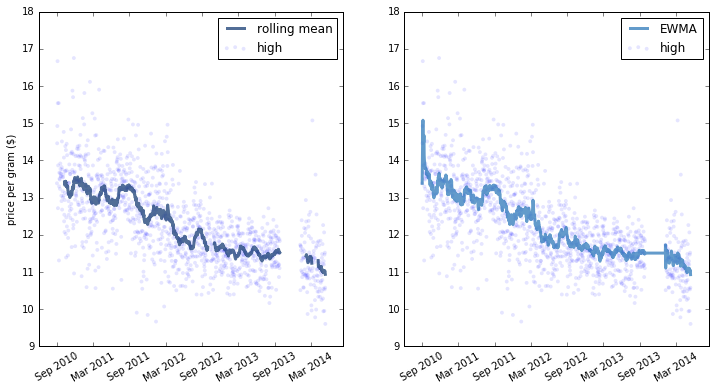

In [8]:
def PlotRollingMean(daily, name):
    """Plots rolling mean and EWMA.

    daily: DataFrame of daily prices
    """
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.PrePlot(cols=2)
    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.1, label=name)
    # roll_mean = pandas.rolling_mean(reindexed.ppg, 30)
    roll_mean = pandas.Series(reindexed.ppg).rolling(window=30).mean()
    thinkplot.Plot(roll_mean, label='rolling mean')
    pyplot.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

    thinkplot.SubPlot(2)
    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.1, label=name)
    # ewma = pandas.ewma(reindexed.ppg, span=30)
    ewma = pandas.Series(reindexed.ppg).ewm(span=30).mean()
    thinkplot.Plot(ewma, label='EWMA')
    pyplot.xticks(rotation=30)
PlotRollingMean(daily, name)

上左图：滚动均值似乎很好地对噪音进行了平滑处理，提取出了趋势。

另一种移动平均值是指数权重移动平均(exponentially-weighted moving average,EWMA)。两个优点：
- 指数权重移动平均计算加权平均值，最近的值具有最高的权重，之前值的权重指数级降低。
- pandas的EWMA实现可以较好地处理缺失值。

## 缺失值
填充缺失值，一种办法是使用移动平均值。这一办法的缺点是弱化了序列中的噪音，这一问题可以通过添加重抽样的残差解决。

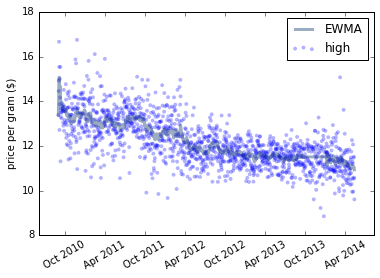

In [9]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pandas.Series(reindexed.ppg).ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.3, label=name)
    thinkplot.Plot(filled.ewma, label='EWMA', alpha=0.4)
    pyplot.xticks(rotation=30)
    thinkplot.Config(root='timeseries8',
                   ylabel='price per gram ($)')
PlotFilled(daily, name)

## 序列相关
如果周一价格很高，可能随后几天都会较高；如果价格很低，可能会保持低位。在这种模式下，每个值都与序列中的下一个值相关，因此称为序列相关(serial correlation)。要计算序列相关，可以将时间序列移动一个称为滞后(lag)间隔，然后计算移动后的序列与原序列的相关性。

In [10]:
def PrintSerialCorrelations(dailies):
    """Prints a table of correlations with different lags.

    dailies: map from category name to DataFrame of daily prices
    """
    filled_dailies = {}
    for name, daily in dailies.items():
        filled_dailies[name] = FillMissing(daily, span=30)

    # print serial correlations for raw price data
    for name, filled in filled_dailies.items():            
        corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
        print(name, corr)

    rows = []
    for lag in [1, 7, 30, 365]:
        row = [str(lag)]
        for name, filled in filled_dailies.items():            
            corr = thinkstats2.SerialCorr(filled.resid, lag)
            row.append('%.2g' % corr)
        rows.append(row)

    print(r'lag | high | medium | low ')
    for row in rows:
        print(' | '.join(row))

    filled = filled_dailies['high']
    acf = smtsa.acf(filled.resid, nlags=365, unbiased=True)
    print('%0.3f, %0.3f, %0.3f, %0.3f, %0.3f' % 
          (acf[0], acf[1], acf[7], acf[30], acf[365]))

PrintSerialCorrelations(dailies)

high 0.488623184682
medium 0.164539864519
low 0.109396705868
lag | high | medium | low 
1 | -0.014 | -0.023 | 0.038
7 | 0.016 | -0.04 | -0.018
30 | 0.0011 | 0.0022 | -0.023
365 | 0.063 | 0.0043 | 0.04
1.000, -0.014, 0.016, 0.001, 0.061


以lag为1运行，得到结果：高质量大麻的序列相关为0.48，中等质量为0.16，低质量为0.10。任何具有长期趋势的时间序列都具有很强的序列相关。

减去这个趋势后，检验这种相关是否依然存在，在lag=1时，高质量为-0.022，中等质量为-0.015，低质量为0.036。这些值都很小，说明序列中的一日序列相关很小或不存在。

使用不同的滞后值，可以检验序列的每周、每月和每年的季节性特征。

## 自相关
自相关函数(autocorrelation function)将滞后值映射到使用该值得到的序列相关。“自相关”是序列相关的另一个名字，常用于滞后值不为1时。

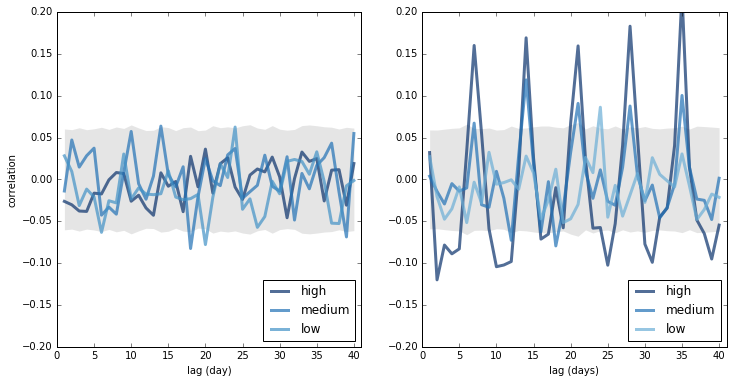

In [12]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')

def AddWeeklySeasonality(daily):
    """Adds a weekly pattern.

    daily: DataFrame of daily prices

    returns: new DataFrame of daily prices
    """
    frisat = (daily.index.dayofweek==4) | (daily.index.dayofweek==5)
    fake = daily.copy()
    fake.ppg.loc[frisat] += np.random.uniform(0, 2, frisat.sum())
    return fake

def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

def MakeAcfPlot(dailies):
    """Makes a figure showing autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices    
    """
    axis = [0, 41, -0.2, 0.2]

    thinkplot.PrePlot(cols=2)
    PlotAutoCorrelation(dailies, add_weekly=False)
    thinkplot.Config(axis=axis, 
                     loc='lower right',
                     ylabel='correlation',
                     xlabel='lag (day)')

    thinkplot.SubPlot(2)
    PlotAutoCorrelation(dailies, add_weekly=True)
    thinkplot.Config(root='timeseries9',
                   axis=axis,
                   loc='lower right',
                   xlabel='lag (days)')
dailies = GroupByQualityAndDay(transactions)
MakeAcfPlot(dailies)

上左图展示了nlags=40时，3种质量分类的自相关函数。图中的灰色区域（是通过对残差的重抽样计算得到的）是不存在自相关时的正态可变性，位于这个区域之外的都是统计显著的，p值小于5%。误报率为5%，因此计算120个相关时(3个时间序列，每个序列40个滞后值)，大约会有6个点在灰色区域之外。实际上，图中有7个点在灰色区域外。我们据此认为，在这些序列中，不存在无法用偶然性解释的自相关。

为了展示存在季节性因素的自相关函数，在数据中加入一个每周的循环进行模拟。假设在周末时大麻的需求量很大，那么价格可能会较高。为了模拟这个效果，选取周五或周六的日期，在价格上添加一个随机量，这个随机量选自从0~2美元的均匀分布。

上右图展示了添加了模拟季节性的价格自相关函数。正如预期，当滞后为7的倍数时，相关性最高。对于高质量和中等质量大麻，新得到的相关是统计显著的。而低质量大麻则不然，因为这一分类的残差最大，必须使用更大的模拟值，才能使效应在噪音中显现出来。

## 预测
需要考虑3种误差来源：
- 抽样误差：预测基于估计参数，而估计参数依赖样本中的随机变异。如果重复进行实验，估计值会发生变化。
- 随机变异：即使估计参数是完美的，观测数据也会在长期趋势附近随机变动，这种变异在未来也会持续出现。
- 建模误差：前面已经有示例证明长期趋势不是线性的，因此，基于线性模型的预测终究会失败。

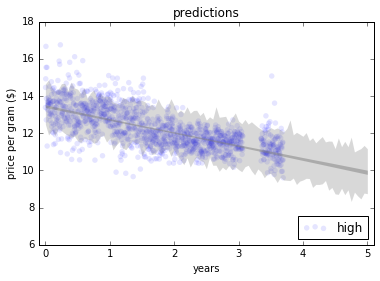

In [13]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pandas.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(root='timeseries4',
               title='predictions',
               xlabel='years',
               xlim=xlim,
               ylabel='price per gram ($)')

图中浅灰色区域展示了预测误差的90%置信区间，预测误差是取样误差和随机变异的和。

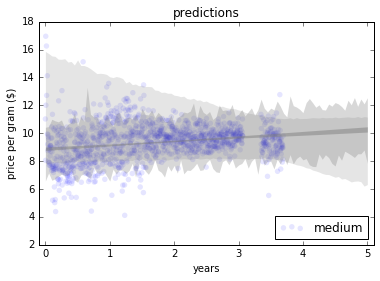

In [14]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')


name = 'medium'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(root='timeseries5',
               title='predictions',
               xlabel='years',
               xlim=xlim,
               ylabel='price per gram ($)')

图中展示了中等质量分类的预测结果。图中最浅的灰色区域代表各种误差的置信区间，包括取样误差、随机变异和观测区间变化。